In [1]:

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import gpflow

from scipy.stats import norm

from gpflow.functions import Constant, Polynomial

from rcgp_batch.rcgp.rcgp import RCGPR
from rcgp_batch.rcgp.w import IMQ

plt.rcParams['text.usetex'] = True

In [2]:
def coverage(preds, std, Ys):
    quantiles = np.append(np.arange(0.05, 1, 0.05), 0.9973)
    coverage_vals = []
    for confidence_level in quantiles:
        z_val = norm.ppf(1 - (1 - confidence_level)/2)
        lb = preds - z_val * std
        ub = preds + z_val * std

        is_within_bounds = (Ys >= lb) & (Ys <= ub)
        coverage_vals.append(is_within_bounds.mean())
    
    return quantiles, coverage_vals

In [3]:
class CustomMeanFunction(gpflow.functions.MeanFunction):
    def __call__(self, X: gpflow.base.TensorType) -> tf.Tensor:
        return tf.sin(2 * np.pi * X)

In [4]:
"""def generate_data(lengthscale, variance_kernel, var_y, n, seed=0):
    np.random.seed(seed)
    kernel = gpflow.kernels.SquaredExponential(variance=variance_kernel, lengthscales=lengthscale)
    X = np.linspace(-5, 5, n)[:, None]  # 100 points in [-5, 5]

    # Compute the covariance matrix using the kernel
    K = kernel(X).numpy()  # Kernel matrix

    # Add a small jitter for numerical stability
    jitter = 1e-6
    K += jitter * np.eye(len(X))

    # Generate samples from the Gaussian Process
    mean = np.zeros(len(X))  # Mean function (zero mean)
    mean_func = np.random.multivariate_normal(mean, K, size=1).flatten()  # 3 sample paths

    y = mean_func +  np.random.normal(0, np.sqrt(var_y), size=len(X))

    return X.flatten(), y.flatten(), mean_func"""


'def generate_data(lengthscale, variance_kernel, var_y, n, seed=0):\n    np.random.seed(seed)\n    kernel = gpflow.kernels.SquaredExponential(variance=variance_kernel, lengthscales=lengthscale)\n    X = np.linspace(-5, 5, n)[:, None]  # 100 points in [-5, 5]\n\n    # Compute the covariance matrix using the kernel\n    K = kernel(X).numpy()  # Kernel matrix\n\n    # Add a small jitter for numerical stability\n    jitter = 1e-6\n    K += jitter * np.eye(len(X))\n\n    # Generate samples from the Gaussian Process\n    mean = np.zeros(len(X))  # Mean function (zero mean)\n    mean_func = np.random.multivariate_normal(mean, K, size=1).flatten()  # 3 sample paths\n\n    y = mean_func +  np.random.normal(0, np.sqrt(var_y), size=len(X))\n\n    return X.flatten(), y.flatten(), mean_func'

In [5]:
"""obs_grid, obs, mean_func = generate_data(1., 0.2, 0.01, 80, seed=3)


obs_outliers = obs.copy()
outliers_idx = [45, 46, 47, 48, 49]
obs_outliers[outliers_idx] = np.random.normal(obs.mean()+2, 0.3, len(outliers_idx))

plt.plot(obs_grid, obs, '.')
plt.plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', color='red')
plt.plot(obs_grid, mean_func, color='black')"""

"obs_grid, obs, mean_func = generate_data(1., 0.2, 0.01, 80, seed=3)\n\n\nobs_outliers = obs.copy()\noutliers_idx = [45, 46, 47, 48, 49]\nobs_outliers[outliers_idx] = np.random.normal(obs.mean()+2, 0.3, len(outliers_idx))\n\nplt.plot(obs_grid, obs, '.')\nplt.plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', color='red')\nplt.plot(obs_grid, mean_func, color='black')"

outlier center :  0.762025316455696


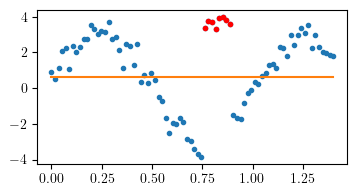

In [6]:
np.random.seed(0)
n_data = 80
n_outliers = 8

obs_grid = np.linspace(0., 1.4, n_data)
true_func = lambda grid : 3 * np.sin(2 * np.pi * grid)
obs = true_func(obs_grid) + np.random.normal(0, 0.5, len(obs_grid))

center_outliers = 43
outliers_idx = np.arange(len(obs))[center_outliers : center_outliers + n_outliers]

obs_outliers = obs.copy()

obs_outliers[outliers_idx] = np.random.normal(obs.mean()+3, 0.2, n_outliers)

plt.figure(figsize=(4,2))
plt.plot(obs_grid, obs_outliers, '.')
plt.plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', color='red')
plt.plot(obs_grid, obs.mean() + np.zeros_like(obs_grid))

print('outlier center : ', obs_grid[center_outliers])

In [7]:
"""c = np.quantile(np.abs(obs - SineMeanFunction()(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) 

print("C : ", c)

model = RCGPR(
    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),
    # The original notebook does not initialize the parameters to specific values.
    # The results don't seem sensitive to this though, given the fixed noise.
    kernel=gpflow.kernels.SquaredExponential(),  
    weighting_function=IMQ(c),
    mean_function=Constant(obs.mean()),
    noise_variance=0.001
)

# setting C trainable to False is critical in getting this to work
learn_C = False
gpflow.set_trainable(model.weighting_function.C, learn_C)
#gpflow.set_trainable(model.mean_function.c, False)
#gpflow.set_trainable(model.likelihood.variance, False)
#gpflow.set_trainable(model.likelihood.variance, True)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)
print(res)
gpflow.utilities.print_summary(model, "notebook")"""


'c = np.quantile(np.abs(obs - SineMeanFunction()(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) \n\nprint("C : ", c)\n\nmodel = RCGPR(\n    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),\n    # The original notebook does not initialize the parameters to specific values.\n    # The results don\'t seem sensitive to this though, given the fixed noise.\n    kernel=gpflow.kernels.SquaredExponential(),  \n    weighting_function=IMQ(c),\n    mean_function=Constant(obs.mean()),\n    noise_variance=0.001\n)\n\n# setting C trainable to False is critical in getting this to work\nlearn_C = False\ngpflow.set_trainable(model.weighting_function.C, learn_C)\n#gpflow.set_trainable(model.mean_function.c, False)\n#gpflow.set_trainable(model.likelihood.variance, False)\n#gpflow.set_trainable(model.likelihood.variance, True)\nopt = gpflow.optimizers.Scipy()\nopt_options = dict()\nres = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)\nprint(res)\ngpflow.utilities.

### Constant Mean

In [8]:
c = np.quantile(np.abs(obs - Constant(obs.mean())(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) 

#Train on non-outliers
model = RCGPR(
    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),
    kernel=gpflow.kernels.SquaredExponential(),  
    weighting_function=IMQ(c),
    mean_function=Constant(obs.mean()),
    noise_variance=0.001
)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
gpflow.set_trainable(model.weighting_function.C, False)

res = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)

#Inference on outliers
model_inference_const = RCGPR(
    (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
    kernel=model.kernel,  
    weighting_function=model.weighting_function,
    mean_function=model.mean_function,
    noise_variance=model.likelihood.variance
)

f_mean_dsm_const, f_var_dsm_const = model_inference_const.predict_f(obs_grid.reshape(-1,1), full_cov=False)

f_std_dsm_const = np.sqrt(f_var_dsm_const).flatten()

weights_constant_mean = model.weighting_function.W(y = obs - model.mean_function(obs_grid), X=None).numpy()

### Sine Mean

In [9]:
c = np.quantile(np.abs(obs - CustomMeanFunction()(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) 

#Train on non-outliers
model_sine = RCGPR(
    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),
    kernel=gpflow.kernels.SquaredExponential(),  
    weighting_function=IMQ(c),
    mean_function=CustomMeanFunction(),
    noise_variance=0.001
)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
gpflow.set_trainable(model_sine.weighting_function.C, False)

res = opt.minimize(model_sine.training_loss_closure(), model_sine.trainable_variables, options=opt_options)

#Inference on Outliers
model_inference_sine = RCGPR(
    (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
    kernel=model_sine.kernel,  
    weighting_function=model_sine.weighting_function,
    mean_function=model_sine.mean_function,
    noise_variance=model_sine.likelihood.variance
)

f_mean_dsm_sine, f_var_dsm_sine = model_inference_sine.predict_f(obs_grid.reshape(-1,1), full_cov=False)
f_mean_dsm_sine = f_mean_dsm_sine.numpy().flatten()

f_std_dsm_sine = np.sqrt(f_var_dsm_sine).flatten()

### GP Regression - Constant Mean

In [10]:
std_gp_model = gpflow.models.GPR(
    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),
    kernel=gpflow.kernels.SquaredExponential(),  
    mean_function=Constant(0),
    noise_variance=0.1
)

opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(std_gp_model.training_loss_closure(), std_gp_model.trainable_variables, options=opt_options)


std_gp_inference = gpflow.models.GPR(
    (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
    kernel=std_gp_model.kernel,  
    mean_function=std_gp_model.mean_function,
    noise_variance=std_gp_model.likelihood.variance
)

f_mean_sgp, f_var_sgp = std_gp_inference.predict_f(obs_grid.reshape(-1,1), full_cov=False)

f_std_sgp = np.sqrt(f_var_sgp).flatten()

In [11]:
c_heuristic = np.quantile(np.abs(obs - CustomMeanFunction()(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) 

preds_c = []
stds_c = []
c_vals = []
coverage_vals_arrs = []
weights_vals = []

for c_val in [0.8, c_heuristic]:

    #Using last model's var and kernel (sine)
    model_c = RCGPR(
                    (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
                    kernel=model_sine.kernel,  
                    weighting_function=IMQ(C=c_val),
                    mean_function=model_sine.mean_function,
                    noise_variance=model_sine.likelihood.variance
                    )

    f_mean_dsm_c, f_var_dsm_c = model_c.predict_f(obs_grid.reshape(-1,1), full_cov=False)
    f_mean_dsm_c = f_mean_dsm_c.numpy().flatten()
    f_var_dsm_c = f_var_dsm_c.numpy().flatten()
    std = np.sqrt(f_var_dsm_c + model_c.likelihood.variance.numpy())

    weights = model_c.weighting_function.W(y = obs - model_c.mean_function(obs_grid), X=None).numpy()

    quantiles, coverage_vals = coverage(preds=f_mean_dsm_c, std=std, Ys=obs)

    coverage_vals_arrs.append(coverage_vals)
    preds_c.append(f_mean_dsm_c)
    stds_c.append(std)
    c_vals.append(c_val)
    weights_vals.append(weights)

model_best_c = RCGPR(
                (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
                kernel=model_sine.kernel,  
                weighting_function=IMQ(C=1.0),
                mean_function=model_sine.mean_function,
                noise_variance=model_sine.likelihood.variance
                )

f_mean_model_best_c, f_var_model_best_c = model_best_c.predict_f(obs_grid.reshape(-1,1), full_cov=False)
f_mean_model_best_c = f_mean_model_best_c.numpy().flatten()
f_var_model_best_c = np.sqrt(f_var_model_best_c).flatten()

Q_n 3.6549961512695353


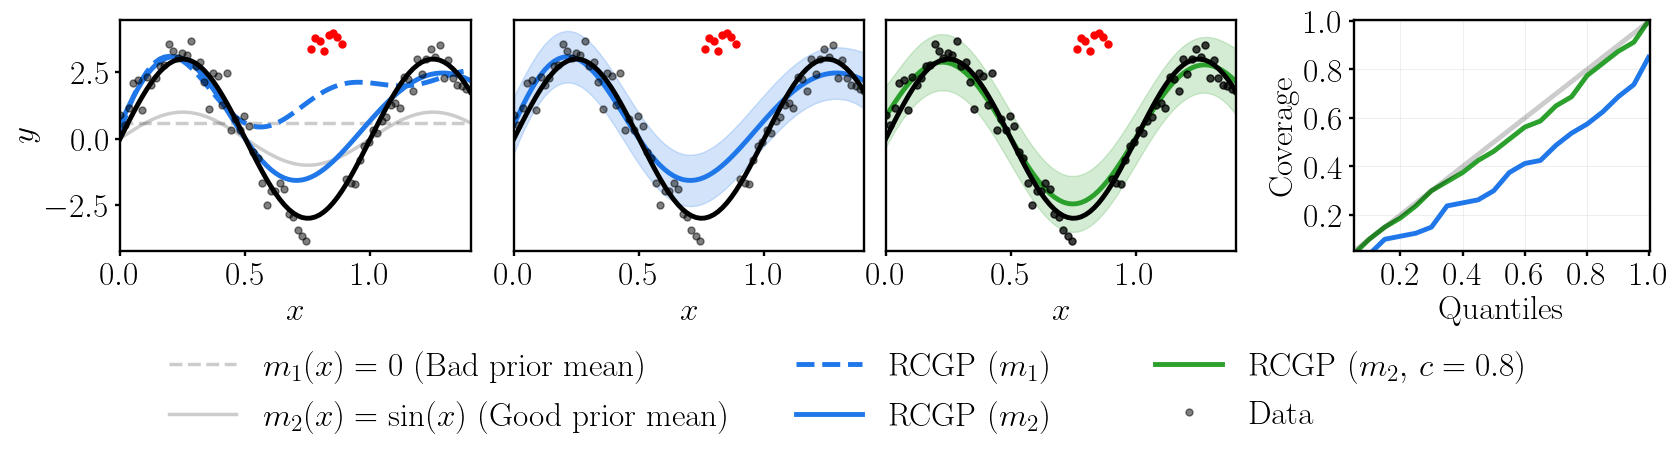

In [ ]:
plt.rc('font', family='serif', size=24)

fig, axs = plt.subplot_mosaic(
    """ABCD""",
     figsize=(20,3.),
     gridspec_kw={"width_ratios": [1.3, 1.3, 1.3, 1.1]},
     )

plt.rcParams['lines.linewidth'] = 3.5

mask = ~np.isin(np.arange(len(obs_grid)), outliers_idx)  # True for non-outliers

color = "#1f77e9"
#axs['A'].plot(obs_grid, f_mean_sgp, color='green', label='GP (Const.)')
axs['A'].plot(obs_grid, np.zeros_like(obs_grid) + obs.mean(), color='black', alpha=0.2, linestyle='--', linewidth=2.5, label=r'$m_1(x)=0$ (Bad prior mean)')
axs['A'].plot(obs_grid, model_inference_sine.mean_function(obs_grid).numpy(), color='black', alpha=0.2, linestyle='-', linewidth=2.5, label=r'$m_2(x)=\sin (x)$ (Good prior mean)')
axs['A'].plot(obs_grid, f_mean_dsm_const, '--', color=color, label=r'RCGP ($m_1$)')
axs['A'].plot(obs_grid, f_mean_dsm_sine, '-', color=color, label = r'RCGP ($m_2$)')

axs['A'].set_xlim(obs_grid[0], obs_grid[-1])

#Second Plot
colors = [
    "#2ca02c",   # Forest Green
    "#1f77e9",  # Custom Blue
]
for pred, std, c_val, col, ax in zip(preds_c, stds_c, c_vals, colors, [axs["C"], axs["B"]]):
    if c_val == c_heuristic: label=""
    else: label=r"RCGP ($m_2,\, c={:.1f}$)".format(c_val)
    ax.plot(obs_grid, pred, color=col, label=label)
    ax.fill_between(obs_grid, pred - 1.96*std, pred + 1.96*std, color=col, alpha=0.2)

    ax.set_xlim(obs_grid[0], obs_grid[-1])
    ax.sharey(axs["A"])
    ax.tick_params(left=False, labelleft=False)


#Third Plot
for coverage_vals, col, label in zip(coverage_vals_arrs, colors, c_vals):
    axs['D'].plot(quantiles, coverage_vals, color=col, label=label)

axs['D'].grid(alpha=0.2)
axs['D'].plot(quantiles, quantiles, '-', color='black', alpha=0.2)
axs['D'].set_xlim(quantiles[0], quantiles[-1]+0.005)
axs['D'].set_ylim(quantiles[0], quantiles[-1]+0.005)


axs['D'].set_ylabel("Coverage", fontsize=24)
axs['D'].set_xlabel("Quantiles", fontsize=24)

axs['D'].set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs['D'].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])

#axs[2].legend()
"""
axs[2].fill_between(obs_grid,
                    f_mean_dsm_sine - 1.96 * np.sqrt(f_std_dsm_sine**2 + model_sine.likelihood.variance),
                    f_mean_dsm_sine + 1.96 * np.sqrt(f_std_dsm_sine**2 + model_sine.likelihood.variance),
                    color=color,
                    alpha=0.2,
                    label=r'$Q_n$')

axs[2].fill_between(obs_grid,
                    f_mean_model_best_c - 1.96 * np.sqrt(f_var_model_best_c + model_best_c.likelihood.variance),
                    f_mean_model_best_c + 1.96 * np.sqrt(f_var_model_best_c + model_best_c.likelihood.variance),
                    color='orange',
                    alpha=0.2,
                    label=r'$Q_n$')"""

for idx in ["A", "B", "C"]:
    if idx=="C":
        axs[idx].plot(obs_grid[mask], obs[mask], '.', color='black', markersize=10, alpha=0.5, label="Data")

    axs[idx].plot(obs_grid[mask], obs[mask], '.', color='black', markersize=10, alpha=0.5)
    #axs[idx].plot(obs_grid[outliers_idx], obs[outliers_idx], '.', color='orange', markersize=5.9)
    axs[idx].plot(obs_grid, true_func(obs_grid), '-', color='black')
    axs[idx].plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', markersize=10, color='red')



for ax in [axs['A'], axs['B'], axs['C'], axs['D']]:
    # Set linewidth for all spines of each axis
    for spine in ax.spines.values():
        spine.set_linewidth(1.7) 
    ax.tick_params(width=1.7)



# Adjust subplot positions to reduce space between A and B
pos_A = axs["A"].get_position()
pos_B = axs["B"].get_position()
pos_C = axs["C"].get_position()
pos_D = axs["D"].get_position()

# Reduce the horizontal space between A and B
axs["A"].set_position([pos_A.x0, pos_A.y0, pos_A.width, pos_A.height])
axs["B"].set_position([pos_B.x0 - 0.012, pos_B.y0, pos_B.width, pos_B.height])
axs["C"].set_position([pos_C.x0 - 0.035, pos_C.y0, pos_C.width, pos_C.height])
axs["D"].set_position([pos_D.x0 - 0.01, pos_D.y0, pos_D.width, pos_D.height])

axs["A"].set_xlabel(r"$x$", fontsize=24)
axs["B"].set_xlabel(r"$x$", fontsize=24)
axs["C"].set_xlabel(r"$x$", fontsize=24)

axs["A"].set_ylabel(r"$y$", fontsize=24)

"""axs["A"].set_title("Issue 1", fontweight='bold', fontsize=16)
axs["B"].set_title("Issue 2", fontweight='bold', fontsize=16)
axs["C"].set_title("Issue 3", fontweight='bold', fontsize=16)"""

axs['A'].legend(loc="upper center", bbox_to_anchor=(1.4, -0.3), ncols=2, fontsize=24, columnspacing=2, frameon=False) #2x2 labls
#axs['B'].legend(loc="upper center", bbox_to_anchor=(1.45, -0.3), ncols=1, fontsize=24, columnspacing=1.5, frameon=False) #rcgp sine blue label
axs['C'].legend(loc="upper center", bbox_to_anchor=(1.3, -0.3), ncols=1, fontsize=24, columnspacing=2, frameon=False) #green rcgp since

#fig.savefig("./rcgp-issues.pdf", format='pdf', bbox_inches='tight')

print("Q_n", c_heuristic)


Q_n 3.6549961512695353


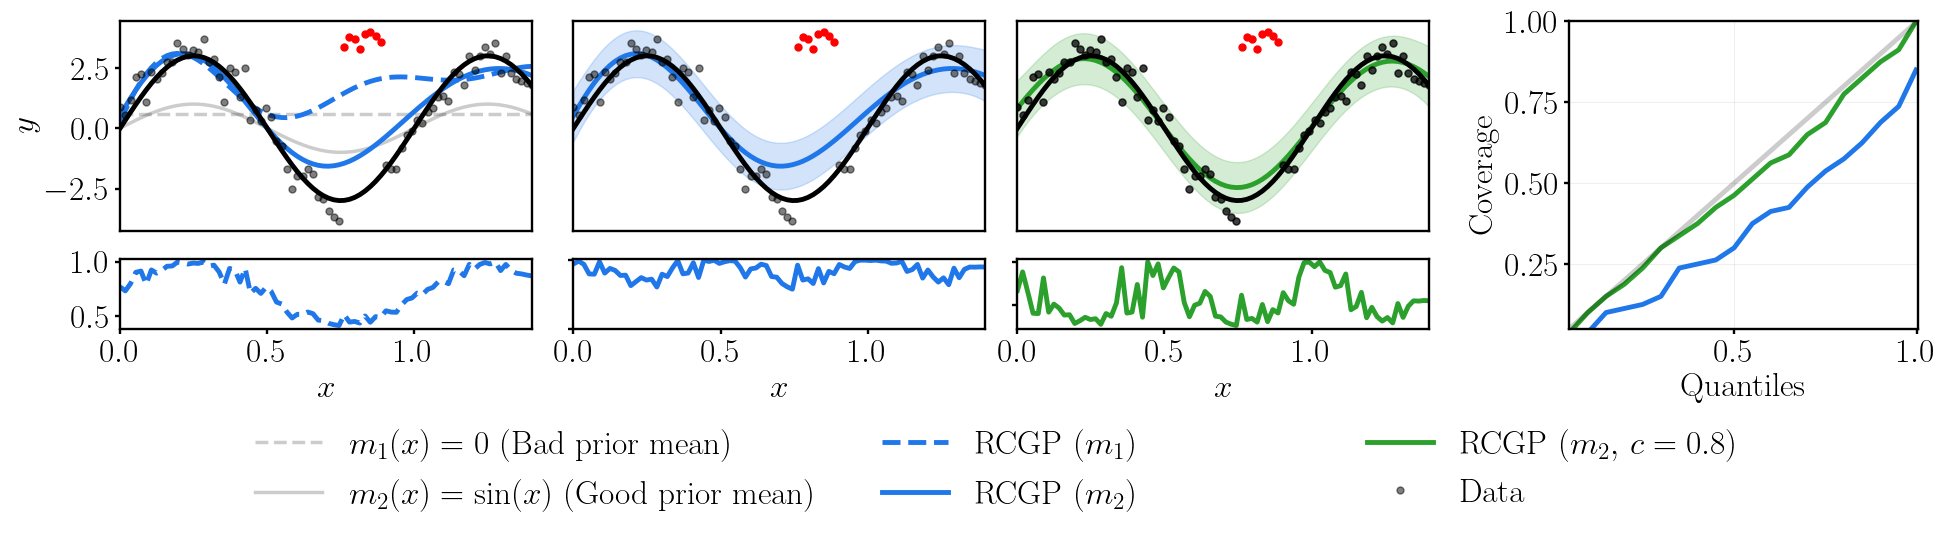

In [13]:
plt.rc('font', family='serif', size=24)

fig, axs = plt.subplot_mosaic(
    """ABCD
       EFGD""",
     figsize=(23.5,4.),
     gridspec_kw={"width_ratios": [1.3, 1.3, 1.3, 1.1], "height_ratios": [3, 1]},
     )

plt.rcParams['lines.linewidth'] = 3.5

mask = ~np.isin(np.arange(len(obs_grid)), outliers_idx)  # True for non-outliers

color = "#1f77e9"
#axs['A'].plot(obs_grid, f_mean_sgp, color='green', label='GP (Const.)')
axs['A'].plot(obs_grid, np.zeros_like(obs_grid) + obs.mean(), color='black', alpha=0.2, linestyle='--', linewidth=2.5, label=r'$m_1(x)=0$ (Bad prior mean)')
axs['A'].plot(obs_grid, model_inference_sine.mean_function(obs_grid).numpy(), color='black', alpha=0.2, linestyle='-', linewidth=2.5, label=r'$m_2(x)=\sin (x)$ (Good prior mean)')
axs['A'].plot(obs_grid, f_mean_dsm_const, '--', color=color, label=r'RCGP ($m_1$)')
axs['A'].plot(obs_grid, f_mean_dsm_sine, '-', color=color, label = r'RCGP ($m_2$)')

axs['A'].set_xlim(obs_grid[0], obs_grid[-1])

#Second Plot
colors = [
    "#2ca02c",   # Forest Green
    "#1f77e9",  # Custom Blue
]
for pred, std, c_val, col, ax in zip(preds_c, stds_c, c_vals, colors, [axs["C"], axs["B"]]):
    if c_val == c_heuristic: label=""
    else: label=r"RCGP ($m_2,\, c={:.1f}$)".format(c_val)
    ax.plot(obs_grid, pred, color=col, label=label)
    ax.fill_between(obs_grid, pred - 1.96*std, pred + 1.96*std, color=col, alpha=0.2)

    ax.set_xlim(obs_grid[0], obs_grid[-1])
    ax.sharey(axs["A"])
    ax.tick_params(left=False, labelleft=False)


#Third Plot
for coverage_vals, col, label in zip(coverage_vals_arrs, colors, c_vals):
    axs['D'].plot(quantiles, coverage_vals, color=col, label=label)

axs['D'].grid(alpha=0.2)
axs['D'].plot(quantiles, quantiles, '-', color='black', alpha=0.2)
axs['D'].set_xlim(quantiles[0], quantiles[-1]+0.005)
axs['D'].set_ylim(quantiles[0], quantiles[-1]+0.005)


axs['D'].set_ylabel("Coverage", fontsize=24)
axs['D'].set_xlabel("Quantiles", fontsize=24)

#axs[2].legend()
"""
axs[2].fill_between(obs_grid,
                    f_mean_dsm_sine - 1.96 * np.sqrt(f_std_dsm_sine**2 + model_sine.likelihood.variance),
                    f_mean_dsm_sine + 1.96 * np.sqrt(f_std_dsm_sine**2 + model_sine.likelihood.variance),
                    color=color,
                    alpha=0.2,
                    label=r'$Q_n$')

axs[2].fill_between(obs_grid,
                    f_mean_model_best_c - 1.96 * np.sqrt(f_var_model_best_c + model_best_c.likelihood.variance),
                    f_mean_model_best_c + 1.96 * np.sqrt(f_var_model_best_c + model_best_c.likelihood.variance),
                    color='orange',
                    alpha=0.2,
                    label=r'$Q_n$')"""

for idx in ["A", "B", "C"]:
    if idx=="C":
        axs[idx].plot(obs_grid[mask], obs[mask], '.', color='black', markersize=10, alpha=0.5, label="Data")

    axs[idx].plot(obs_grid[mask], obs[mask], '.', color='black', markersize=10, alpha=0.5)
    #axs[idx].plot(obs_grid[outliers_idx], obs[outliers_idx], '.', color='orange', markersize=5.9)
    axs[idx].plot(obs_grid, true_func(obs_grid), '-', color='black')
    axs[idx].plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', markersize=10, color='red')



for ax in [axs['A'], axs['B'], axs['C'], axs['D'], axs["E"], axs["F"], axs["G"]]:
    # Set linewidth for all spines of each axis
    for spine in ax.spines.values():
        spine.set_linewidth(1.7) 
    ax.tick_params(width=1.7)


# Adjust subplot positions to reduce space between A and B
pos_A = axs["A"].get_position()
pos_B = axs["B"].get_position()
pos_C = axs["C"].get_position()
pos_D = axs["D"].get_position()
pos_E = axs["E"].get_position()
pos_F = axs["F"].get_position()
pos_G = axs["G"].get_position()

# Reduce the horizontal space between A and B
axs["A"].set_position([pos_A.x0, pos_A.y0, pos_A.width, pos_A.height])
axs["E"].set_position([pos_E.x0, pos_E.y0, pos_E.width, pos_E.height])

axs["B"].set_position([pos_B.x0 - 0.016, pos_B.y0, pos_B.width, pos_B.height])
axs["F"].set_position([pos_F.x0 - 0.016, pos_F.y0, pos_F.width, pos_F.height])

axs["C"].set_position([pos_C.x0 - 0.036, pos_C.y0, pos_C.width, pos_C.height])
axs["G"].set_position([pos_G.x0 - 0.036, pos_G.y0, pos_G.width, pos_G.height])

axs["D"].set_position([pos_D.x0 - 0.01, pos_D.y0, pos_D.width, pos_D.height])

axs["E"].set_xlabel(r"$x$", fontsize=24)
axs["F"].set_xlabel(r"$x$", fontsize=24)
axs["G"].set_xlabel(r"$x$", fontsize=24)

axs["A"].set_ylabel(r"$y$", fontsize=24)

"""axs["A"].set_title("Issue 1", fontweight='bold', fontsize=16)
axs["B"].set_title("Issue 2", fontweight='bold', fontsize=16)
axs["C"].set_title("Issue 3", fontweight='bold', fontsize=16)"""

axs['A'].legend(loc="upper center", bbox_to_anchor=(1.4, -0.8), ncols=2, fontsize=24, columnspacing=2, frameon=False) #2x2 labls
#axs['B'].legend(loc="upper center", bbox_to_anchor=(1.45, -0.3), ncols=1, fontsize=24, columnspacing=1.5, frameon=False) #rcgp sine blue label
axs['C'].legend(loc="upper center", bbox_to_anchor=(1.3, -0.8), ncols=1, fontsize=24, columnspacing=2, frameon=False) #green rcgp since

#fig.savefig("./rcgp-issues.pdf", format='pdf', bbox_inches='tight')

#removing ticks
for idx in ["A", "B", "C"]: axs[idx].set_xticks([])

#xticks for weights/fit
"""for idx in ["E", "F", "G"]: 
    axs[idx].set_xticks([0, 0.25, 0.5, 0.75, 1])
    axs[idx].set_xticklabels(["0", "0.25", "0.5", "0.75", "1"])"""

axs["E"].plot(obs_grid, weights_constant_mean, color=colors[1], linestyle='--')
axs["G"].plot(obs_grid, weights_vals[0], color=colors[0], linestyle='-')
axs["F"].plot(obs_grid, weights_vals[1], color=colors[1], linestyle='-')

for idx in ["E", "F", "G"]:
    axs[idx].set_xlim(obs_grid[0], obs_grid[-1])
    axs[idx].set_yticks([0.5, 1.0])

for idx in ["F", "G"]: axs[idx].set_yticklabels([])


print("Q_n", c_heuristic)
